In [25]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import shutil
import stat
from git import Repo
from dotenv import load_dotenv
import numpy as np

In [26]:
load_dotenv()
SOURCE_REPO = f"https://github.com/{os.getenv('_STOCK_DB_REPO')}.git"
BRANCH = os.getenv("_BRANCH_NAME", "main")

In [27]:
CLONE_REPO = False 

In [28]:
def remove_readonly(func, path, _):
    os.chmod(path, stat.S_IWRITE)
    func(path)

In [29]:
if CLONE_REPO:
    if os.path.exists("stock-db"):
        shutil.rmtree("stock-db", onerror=remove_readonly)
    Repo.clone_from(SOURCE_REPO, "stock-db", branch=BRANCH)

In [30]:
stock_db_path = "../stock-db"

if os.path.exists(stock_db_path):
    csv_files = [f for f in os.listdir(stock_db_path) if f.endswith('.csv')]
    if csv_files:
        random_csv = random.choice(csv_files)
        random_csv = "BBNI.JK.csv"
        print(f"Using predefined CSV: {random_csv}")
    else:
        print("No CSV files found in stock-db.")
else:
    print("stock-db directory does not exist.")

Using predefined CSV: BBNI.JK.csv


In [31]:
csv_file_path = os.path.join(stock_db_path, random_csv)
df = pd.read_csv(csv_file_path, header=None, skiprows=1)
df[0] = pd.to_datetime(df[0]).dt.date
print(df.head(3))

            0       1       2       3       4         5
0  2022-05-20  4350.0  4462.5  4350.0  4387.5  70372000
1  2022-05-23  4387.5  4487.5  4337.5  4425.0  60898200
2  2022-05-24  4512.5  4587.5  4475.0  4537.5  58031400


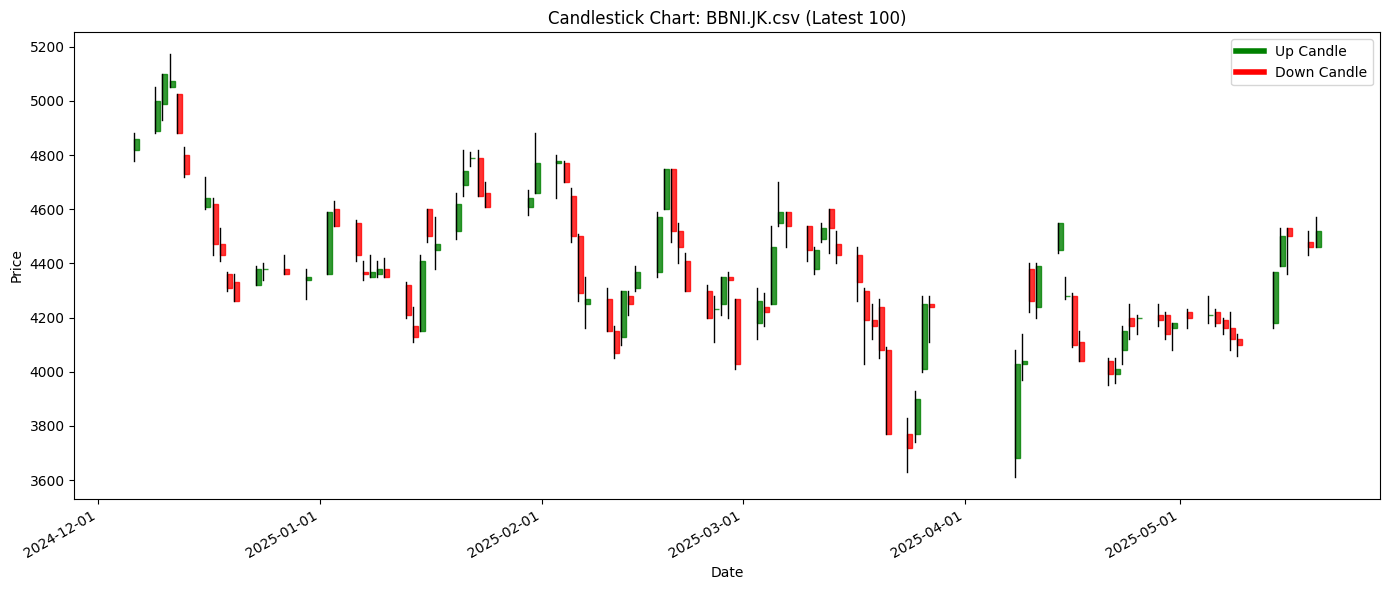

In [32]:
candles = df.tail(100)
fig, ax = plt.subplots(figsize=(14, 6))

for idx, row in candles.iterrows():
    date = row[0]
    open_, high, low, close = row[1], row[2], row[3], row[4]
    color = 'green' if close >= open_ else 'red'
    ax.plot([date, date], [low, high], color='black', linewidth=1)
    rect = Rectangle(
        (mdates.date2num(date), min(open_, close)),
        0.7,
        abs(close - open_),
        color=color,
        alpha=0.8
    )
    ax.add_patch(rect)

ax.set_title(f'Candlestick Chart: {random_csv} (Latest 100)')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

legend_elements = [
    Line2D([0], [0], color='green', lw=4, label='Up Candle'),
    Line2D([0], [0], color='red', lw=4, label='Down Candle')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [33]:
# Calculate tolerance as a percentage of price (e.g., 1%)
tolerance_pct = 0.01

# Combine open and close prices from the candles DataFrame
open_close_prices = np.concatenate([candles[1].values, candles[4].values])

# Sort prices for easier grouping
open_close_prices_sorted = np.sort(open_close_prices)

# Group prices within tolerance
grouped_prices = []
group_counts = []

for price in open_close_prices_sorted:
    if not grouped_prices:
        grouped_prices.append([price])
    else:
        # Compare with the last group's mean
        last_group = grouped_prices[-1]
        if abs(price - np.mean(last_group)) <= tolerance_pct * np.mean(last_group):
            last_group.append(price)
        else:
            grouped_prices.append([price])

# For each group, use the mean as the representative price and count occurrences
group_means = [np.mean(group) for group in grouped_prices]
group_sizes = [len(group) for group in grouped_prices]

# Get the 4 most visited price levels
top_indices = np.argsort(group_sizes)[-4:][::-1]
top_price_levels = [(group_means[i], group_sizes[i]) for i in top_indices]

# Print the 4 most visited price levels (support/resistance)
for i, (level, count) in enumerate(top_price_levels, 1):
    print(f"Level {i}: {level:.2f} (visited {count} times)")

Level 1: 4351.89 (visited 37 times)
Level 2: 4186.45 (visited 31 times)
Level 3: 4257.39 (visited 23 times)
Level 4: 4451.50 (visited 20 times)


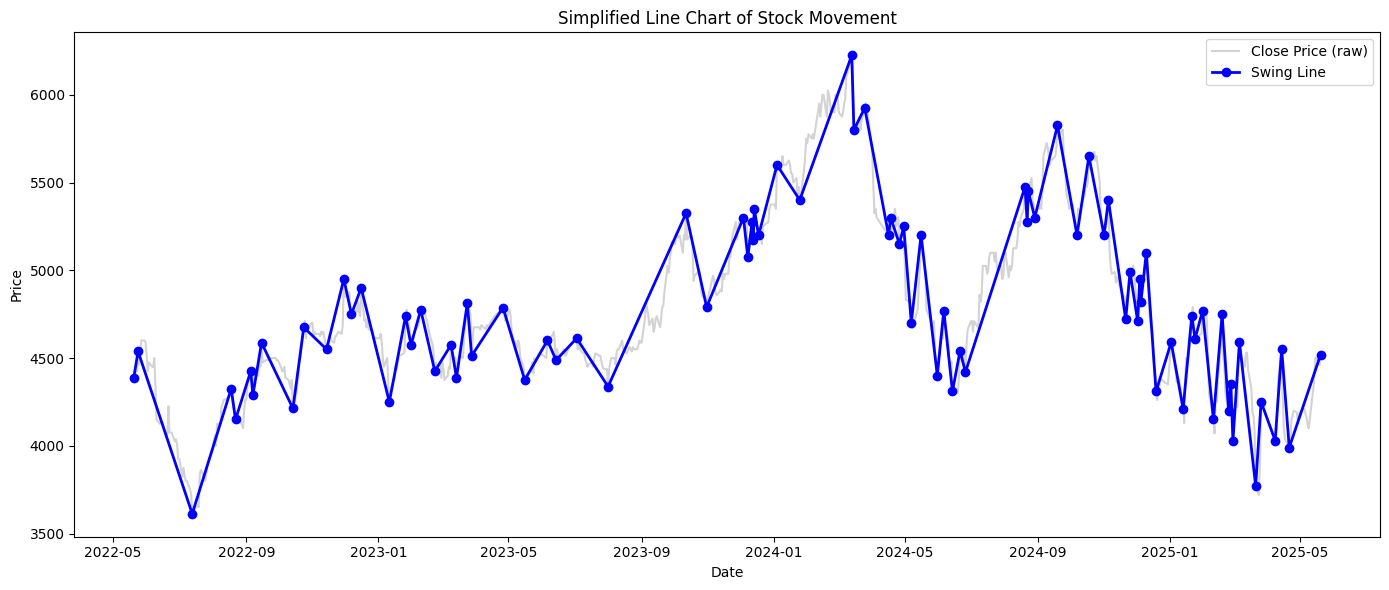

In [34]:
# Use the close price as the main price series
price_series = df[4].values  # column 4 is close price

# Step 1: Filter for significant moves (min_diff)
def filter_significant_moves(prices, min_diff=0):
    if min_diff <= 0 or len(prices) < 2:
        return list(enumerate(prices))
    filtered = [(0, prices[0])]
    last_idx, last_price = 0, prices[0]
    for i in range(1, len(prices)):
        if abs(prices[i] - last_price) >= min_diff:
            filtered.append((i, prices[i]))
            last_idx, last_price = i, prices[i]
    if filtered[-1][0] != len(prices) - 1:
        filtered.append((len(prices) - 1, prices[-1]))
    return filtered

# Step 2: Find peaks and valleys on the filtered points
def find_peaks_and_valleys_on_points(points):
    result = []
    n = len(points)
    if n == 0:
        return result
    result.append(points[0])
    direction = 0  # 1 for up, -1 for down, 0 for unknown
    for i in range(1, n-1):
        prev, curr, next_ = points[i-1][1], points[i][1], points[i+1][1]
        if curr > prev and curr > next_:
            if direction != 1:
                result.append(points[i])
                direction = 1
        elif curr < prev and curr < next_:
            if direction != -1:
                result.append(points[i])
                direction = -1
    if result[-1][0] != points[-1][0]:
        result.append(points[-1])
    return result

min_diff = 100  # adjust as needed
filtered_moves = filter_significant_moves(price_series, min_diff=min_diff)
peaks_valleys = find_peaks_and_valleys_on_points(filtered_moves)

indices, prices = zip(*peaks_valleys)
dates = pd.to_datetime(df[0].values)[list(indices)]

plt.figure(figsize=(14, 6))
plt.plot(df[0], price_series, color='lightgray', label='Close Price (raw)')
plt.plot(dates, prices, marker='o', color='blue', linewidth=2, label='Swing Line')
plt.title('Simplified Line Chart of Stock Movement')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
# Use the peaks and valleys (after min_diff filtering) to count support/resistance levels

# Extract the prices from peaks and valleys
swing_prices = np.array(prices)

# Set tolerance as a percentage (e.g., 1%)
tolerance_pct = 0.01

# Sort swing prices for grouping
swing_prices_sorted = np.sort(swing_prices)

# Group swing prices within tolerance
grouped_swing_prices = []
for price in swing_prices_sorted:
    if not grouped_swing_prices:
        grouped_swing_prices.append([price])
    else:
        last_group = grouped_swing_prices[-1]
        if abs(price - np.mean(last_group)) <= tolerance_pct * np.mean(last_group):
            last_group.append(price)
        else:
            grouped_swing_prices.append([price])

# Calculate mean and count for each group
group_means = [np.mean(group) for group in grouped_swing_prices]
group_sizes = [len(group) for group in grouped_swing_prices]

# Get the 4 most visited swing price levels
top_indices = np.argsort(group_sizes)[-4:][::-1]
top_swing_levels = [(group_means[i], group_sizes[i]) for i in top_indices]

# Print the 4 most visited swing price levels (support/resistance)
for i, (level, count) in enumerate(top_swing_levels, 1):
    print(f"Swing Level {i}: {level:.2f} (visited {count} times)")

Swing Level 1: 4736.14 (visited 11 times)
Swing Level 2: 4592.50 (visited 8 times)
Swing Level 3: 5289.29 (visited 7 times)
Swing Level 4: 5189.29 (visited 7 times)


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df[0], price_series, color='lightgray', label='Close Price (raw)')
plt.plot(dates, prices, marker='o', color='blue', linewidth=2, label='Swing Line')

# Plot the 4 swing levels as horizontal dotted lines
for level, count in top_swing_levels:
    plt.axhline(level, color='orange', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Swing Level {level:.2f}')

# Avoid duplicate legend entries for swing levels
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.title('Simplified Line Chart of Stock Movement with Swing Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()